### Импорт библиотек


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

### Чтение данных


In [3]:
df = pd.read_csv('Titanic.csv')

### Предпросмотр данных и работа с ними


In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


На данном этапе можно убрать следующие данные:

- PassengerID - просто ID пассажира, не может влиять на выживаемость
- Name - уникальное имя пассажира, также не может влиять на его выживаемость
- Embarked - город посадки пассажира, также не может влиять на выживаемость, особенно на больших данных
- Ticket - номер билета пассажира, скорее всего не имеет влияния на выживаемость

In [4]:
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Embarked', axis=1)
df = df.drop('Ticket', axis=1)

#### Работа с NaN

Проверим данные на наличие пропущенных значений.

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687


В качестве результата проверки имеем:

- Cabin - содержит слишком много незаполненных ячеек, попытка заполнения не может быть успешной из-за маленького объема данных

Удалим её для более точной оценки выживаемости:

In [5]:
df = df.drop('Cabin', axis=1)

У нас остается одна котегориальная колонка, переводим:

In [6]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})

----

### Разведочный анализ данных (EDA)


На ящике с усами видно, что мужчины в целом старше и имеют больше выбросов по возрасту:

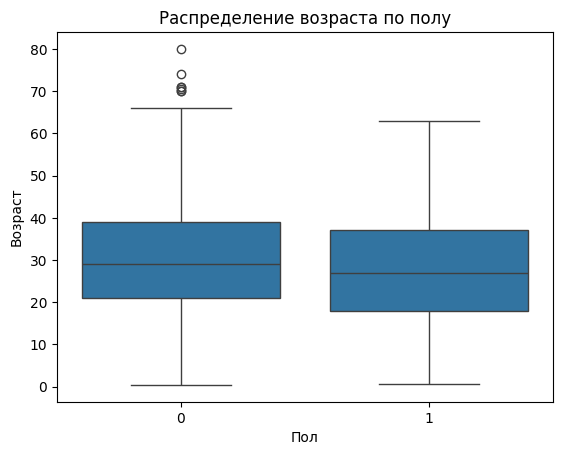

In [7]:
sns.boxplot(x='Sex', y='Age', data=df)
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.title('Распределение возраста по полу')
plt.show()

Пассажиры с 1-3 родственниками выживали чаще, чем одиночки или большие семьи. Параметр является гибридным, поэтому, например, 1 колонке SibSp может обозначать как супруга, так и брата/сестру. Аналогичная проблема присутствует и в колонке Parch. Еще больше усложняет ситуацию то, что на титанике может быть три поколения одной семьи, или, например, дедушка с внуком, что не будет как либо зачислено в датасете. Поэтому параметры объединены в цельный FamilySize, чтобы попробовать нивелировать эту проблему.

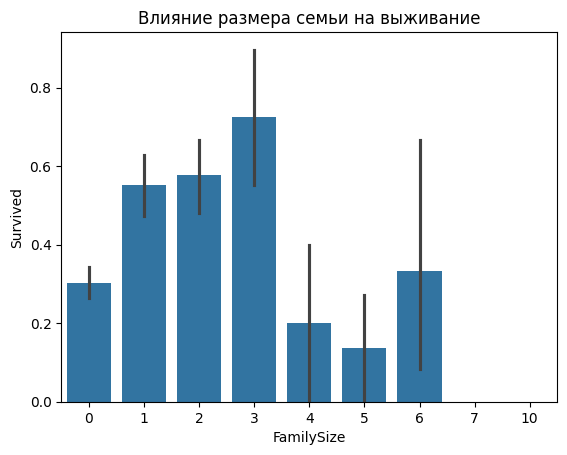

In [8]:
df['FamilySize'] = df['SibSp'] + df['Parch']
sns.barplot(data=df, x='FamilySize', y='Survived')
plt.title('Влияние размера семьи на выживание')
plt.show()

Отбросим изначальные колонки.

In [9]:
df = df.drop(['Parch', 'SibSp'], axis=1)

На графике выживаемости к классу каюты видим очень высокую корреляцию. Пасажиры из более "дорогих" классов кают выживают значительно вероятнее.

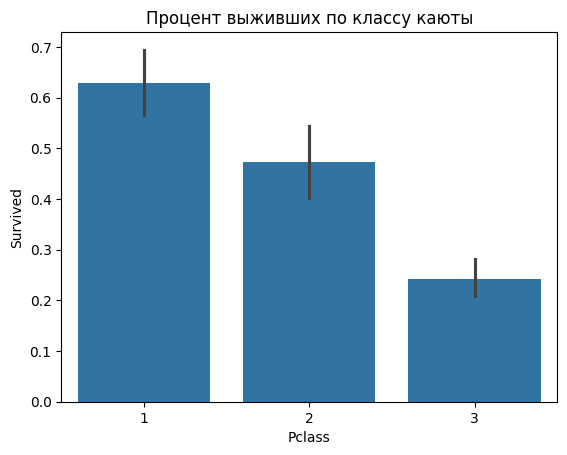

In [10]:
sns.barplot(data=df, x='Pclass', y='Survived')
plt.title('Процент выживших по классу каюты')
plt.show()

Ящик с усами показывает, что в среднем пассажиры с более высокой ценой билета выживали чаще. Необходимо проверить корреляцию с Pclass

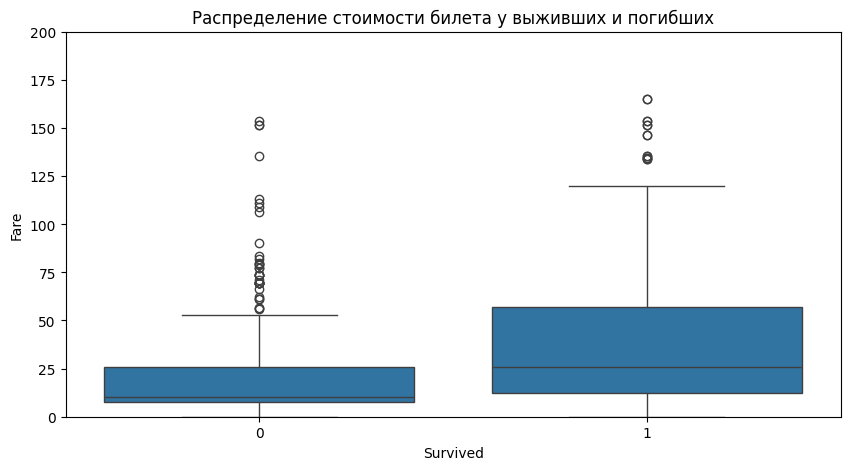

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Survived', y='Fare')
plt.title('Распределение стоимости билета у выживших и погибших')
plt.ylim(0, 200)  # Убираем выбросы
plt.show()

На точечном графике видим, что разброс цены для первого класса был очень большим, поэтому важно сохранить оба параметра, для отличия дорогого второго класса и дешевого первого, к примеру.

C:\Users\chern\AppData\Local\Temp\ipykernel_10108\3588532234.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x='Pclass', y='Fare', jitter=True, alpha=0.5, palette='viridis')


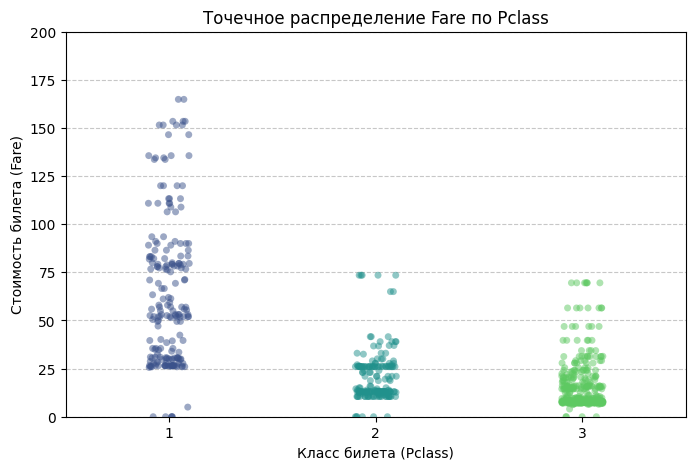

In [12]:
plt.figure(figsize=(8, 5))
sns.stripplot(data=df, x='Pclass', y='Fare', jitter=True, alpha=0.5, palette='viridis')
plt.title('Точечное распределение Fare по Pclass')
plt.xlabel('Класс билета (Pclass)')
plt.ylabel('Стоимость билета (Fare)')
plt.ylim(0, 200)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Модель К-ближайших соседей

На основе графиков мы можем создать модель К-ближайших соседей. Выстраиваем корреляцию возраста с параметрами класса билета, пола и стоимости билета и делаем предсказание для пустых ячеек в колонке Age.

In [13]:
df_train = df[~df['Age'].isnull()]
features = ['Pclass', 'Sex', 'Fare', 'Survived']
model =  KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[features], df_train['Age'])
df_test = df[df['Age'].isnull()]
predicted_age = model.predict(df_test[features])
df.loc[df['Age'].isnull(), 'Age'] = predicted_age

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
Fare,0
FamilySize,0


Присутствует дизбаланс классов. В следствии опираемся на F-метрику для оценки точности модели.

In [ ]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


По графику ниже можем заметить сильную корреляцию с колонками Fare, Pclass, Sex, слабую корреляцию с Age и практически отсутствующую с FamilySize.

In [ ]:
df.corr()

,Survived,Pclass,Sex,Age,Fare,FamilySize
Survived,1.000000,-0.338481,0.543351,-0.111891,0.257307,0.016639
Pclass,-0.338481,1.000000,-0.131900,-0.357595,-0.549500,0.065997
Sex,0.543351,-0.131900,1.000000,-0.132805,0.182333,0.200988
Age,-0.111891,-0.357595,-0.132805,1.000000,0.091416,-0.227301
Fare,0.257307,-0.549500,0.182333,0.091416,1.000000,0.217138
FamilySize,0.016639,0.065997,0.200988,-0.227301,0.217138,1.000000


Удалим колонку Family Size, чтобы не загрязнять данные.

In [14]:
df = df.drop('FamilySize', axis=1)

### Feature Engineering


Добавим новые признаки для улучшения модели:

In [15]:
# Возрастные группы
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 40, 60, 100],
                        labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior'])

# Категории стоимости
df['FareCategory'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

Корреляция новых признаков с таргетом

Возрастные группы. Дети (Child) имеют самый высокий уровень выживаемости (≈58%),
тогда как пожилые (Senior) - самый низкий (≈23%).

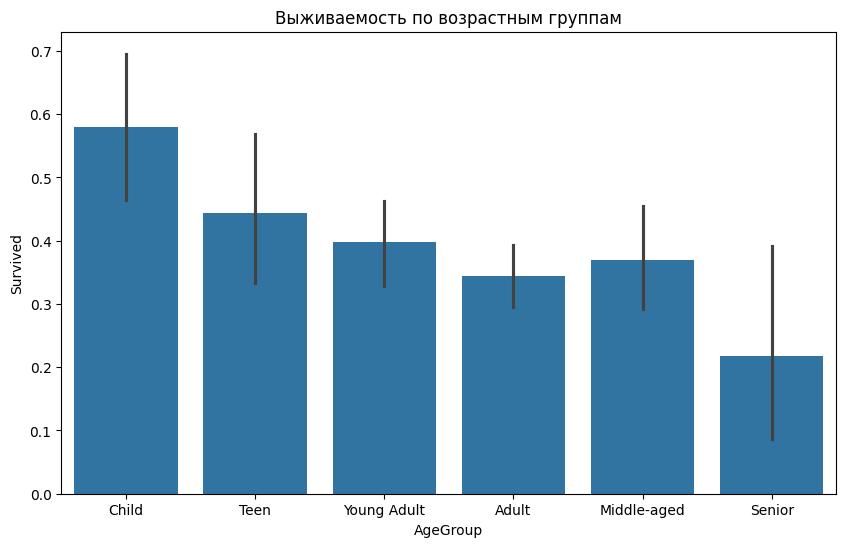

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Survived', data=df, order=['Child', 'Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior'])
plt.title('Выживаемость по возрастным группам')
plt.show()

Категории стоимости билета. Пассажиры с билетами категории "Very High" выживали в ≈58% случаев, тогда как в категории "Low" — только ≈20%. Стоимость билета сильно коррелирует с выживаемостью.

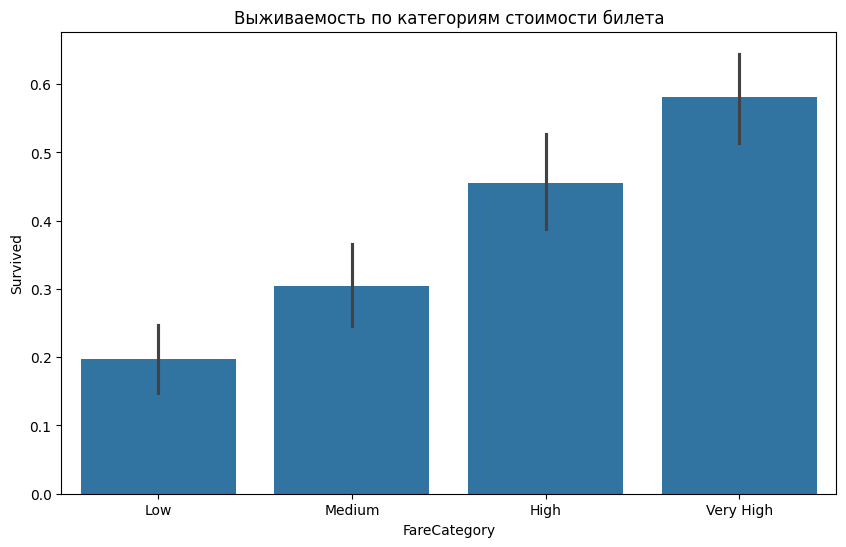

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='FareCategory', y='Survived', data=df, order=['Low', 'Medium', 'High', 'Very High'])
plt.title('Выживаемость по категориям стоимости билета')
plt.show()

Переведем категориальные параметры в числовые:

In [20]:
age_order = ['Child', 'Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior']
df['AgeGroup'] = df['AgeGroup'].apply(lambda x: age_order.index(x) if pd.notnull(x) else -1)

fare_order = ['Low', 'Medium', 'High', 'Very High']
df['FareCategory'] = df['FareCategory'].apply(lambda x: fare_order.index(x) if pd.notnull(x) else -1)

Построим новый график корреляции. Видим более высокую корреляцию AgeGroup, по сравнению с Age, а также более высокую корреляцию FateCategory по сравнению с Fare.

In [ ]:
df.corr()

,Survived,Pclass,Sex,Age,Fare,AgeGroup,FareCategory
Survived,1.000000,-0.338481,0.543351,-0.111891,0.257307,-0.120479,0.299357
Pclass,-0.338481,1.000000,-0.131900,-0.357595,-0.549500,-0.294534,-0.634271
Sex,0.543351,-0.131900,1.000000,-0.132805,0.182333,-0.148983,0.243613
Age,-0.111891,-0.357595,-0.132805,1.000000,0.091416,0.936966,0.092766
Fare,0.257307,-0.549500,0.182333,0.091416,1.000000,0.055567,0.579345
AgeGroup,-0.120479,-0.294534,-0.148983,0.936966,0.055567,1.000000,0.014588
FareCategory,0.299357,-0.634271,0.243613,0.092766,0.579345,0.014588,1.000000


Удалим Age и Fare из-за высокой корреляции с новыми параметрами.

In [21]:
df = df.drop('Age', axis=1)
df = df.drop('Fare', axis=1)

# Feature Importances

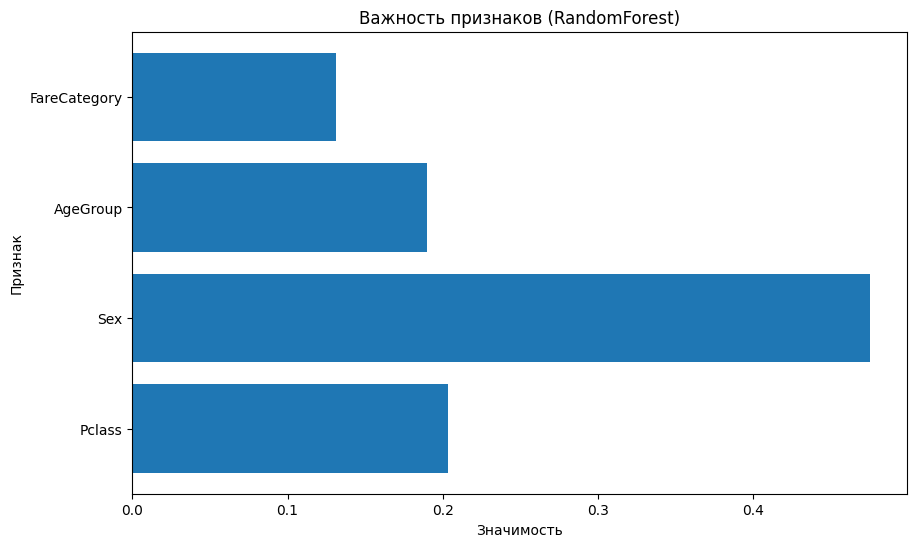

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Подготовка данных
X = df.drop('Survived', axis=1)
y = df['Survived']

# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title('Важность признаков (RandomForest)')
plt.xlabel('Значимость')
plt.ylabel('Признак')
plt.show()

In [23]:
# Удаляем категориальный тип перед преобразованием
df['AgeGroup'] = df['AgeGroup'].astype('object')
df['FareCategory'] = df['FareCategory'].astype('object')

# Явное преобразование в целочисленный тип
df['AgeGroup'] = df['AgeGroup'].astype('int64')
df['FareCategory'] = df['FareCategory'].astype('int64')


# Простые модели

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [113]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

Логистическая регрессия

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

logreg_params = {'C': [0.01, 0.1, 1], 'penalty': ['l2']}
logreg_grid = GridSearchCV(LogisticRegression(random_state=52, max_iter=1000), logreg_params, cv=5)
logreg_grid.fit(X_train, y_train)
linear_model = logreg_grid.best_estimator_

y_pred_linear = linear_model.predict(X_test)
print("Линейная модель (логистическая регрессия):")
print("F1-мера:", f1_score(y_test, y_pred_linear))

Линейная модель (логистическая регрессия):
F1-мера: 0.7920792079207921


Ridge-классификация

In [96]:
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier(random_state=52)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
print("\nЛинейная модель (Ridge):")
print("F1-мера:", f1_score(y_test, y_pred_ridge))


Линейная модель (Ridge):
F1-мера: 0.7547169811320755


с SGD-обучением

In [38]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log_loss', random_state=52)
sgd_model.fit(X_train, y_train)

y_pred_sgd = sgd_model.predict(X_test)
print("\nЛинейная модель (SGD):")
print("F1-мера:", f1_score(y_test, y_pred_sgd))


Линейная модель (SGD):
F1-мера: 0.5128205128205128


# Построение сложных моделей


In [26]:
def get_metrix_of_model(model, epochs, name, X_train, y_train, X_test, y_test, verbose=1):
    """
    Обучает модель и возвращает F1-score и ROC-AUC

    Параметры:
    model - модель Keras
    epochs - количество эпох обучения
    name - название модели (для вывода)
    X_train, y_train - данные для обучения
    X_test, y_test - данные для тестирования
    verbose - уровень детализации (0 - без вывода, 1 - с выводом)
    """
    # Компиляция модели
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Обучение модели
    model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=verbose
    )

    # Предсказания
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    y_proba = model.predict(X_test)

    # Расчёт метрик
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Вывод результатов
    if verbose:
        print(f'\nМодель: {name}')
        print(f'F1-score: {f1:.4f}')
        print(f'ROC-AUC: {roc_auc:.4f}')

    return {
        'f1_score': f1,
        'roc_auc': roc_auc
    }

Простая полносвязная сеть

In [97]:
md1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1, 10, "Простая полносвязная сеть", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6075 - loss: 0.6537 - val_accuracy: 0.7388 - val_loss: 0.5711
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7179 - loss: 0.5803 - val_accuracy: 0.7388 - val_loss: 0.5378
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - loss: 0.5355 - val_accuracy: 0.7313 - val_loss: 0.5023
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7370 - loss: 0.5218 - val_accuracy: 0.7612 - val_loss: 0.4772
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.4844 - val_accuracy: 0.7910 - val_loss: 0.4651
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.4633 - val_accuracy: 0.8060 - val_loss: 0.4560
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - loss: 0.4610 - val_accuracy: 0.7910 - val_loss: 0.4478
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.4661 - val_accuracy: 0.8209 - val_loss: 0.4514
Epo

{'f1_score': 0.7476635514018691, 'roc_auc': np.float64(0.8736263736263736)}

Сеть с дропаутом

In [98]:
md2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md2, 10, "Сеть с дропаутом", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5957 - loss: 0.7351 - val_accuracy: 0.6940 - val_loss: 0.5951
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6613 - loss: 0.6140 - val_accuracy: 0.7388 - val_loss: 0.5565
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6900 - loss: 0.5783 - val_accuracy: 0.7463 - val_loss: 0.5262
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7372 - loss: 0.5337 - val_accuracy: 0.7388 - val_loss: 0.5061
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.5127 - val_accuracy: 0.7388 - val_loss: 0.4904
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7531 - loss: 0.5324 - val_accuracy: 0.7761 - val_loss: 0.4725
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7406 - loss: 0.5013 - val_accuracy: 0.7537 - val_loss: 0.4630
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7578 - loss: 0.4897 - val_accuracy: 0.7537 - val_loss: 0.4571
Epo

{'f1_score': 0.673469387755102, 'roc_auc': np.float64(0.8690476190476191)}

Сеть с рекуррентным слоем

In [99]:
md3 = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
get_metrix_of_model(md3, 10, "Сеть с рекуррентным слоем", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6185 - loss: 0.6790 - val_accuracy: 0.5821 - val_loss: 0.6822
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6258 - loss: 0.6626 - val_accuracy: 0.5821 - val_loss: 0.6705
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6350 - loss: 0.6490 - val_accuracy: 0.5821 - val_loss: 0.6605
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6371 - loss: 0.6385 - val_accuracy: 0.5821 - val_loss: 0.6450
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6263 - loss: 0.6412 - val_accuracy: 0.6418 - val_loss: 0.6367
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6857 - loss: 0.6137 - val_accuracy: 0.6716 - val_loss: 0.6257
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6658 - loss: 0.6214 - val_accuracy: 0.6866 - val_loss: 0.6247
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6976 - loss: 0.6085 - val_accuracy: 0.6940 - val_loss: 0.6101
Epo

{'f1_score': 0.5531914893617021, 'roc_auc': np.float64(0.7818223443223443)}

Лучшая F1-мера у простой полносвязной сети, поэксперементируем с топологией сети:

In [103]:
md1_1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_1, 10, "128-64-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5614 - loss: 0.6662 - val_accuracy: 0.7239 - val_loss: 0.5490
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7152 - loss: 0.5328 - val_accuracy: 0.7537 - val_loss: 0.4876
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7664 - loss: 0.4936 - val_accuracy: 0.7612 - val_loss: 0.4509
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7620 - loss: 0.4838 - val_accuracy: 0.8060 - val_loss: 0.4407
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7957 - loss: 0.4581 - val_accuracy: 0.8433 - val_loss: 0.4353
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 0.4393 - val_accuracy: 0.7910 - val_loss: 0.4352
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.4118 - val_accuracy: 0.7910 - val_loss: 0.4347
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7952 - loss: 0.4378 - val_accuracy: 0.7761 - val_loss: 0.4455
Epo

{'f1_score': 0.7339449541284404, 'roc_auc': np.float64(0.861492673992674)}

In [101]:
md1_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2, 10, "64-128-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5997 - loss: 0.6476 - val_accuracy: 0.7164 - val_loss: 0.5525
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7344 - loss: 0.5456 - val_accuracy: 0.7537 - val_loss: 0.4890
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7327 - loss: 0.5208 - val_accuracy: 0.7985 - val_loss: 0.4583
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.4576 - val_accuracy: 0.7910 - val_loss: 0.4383
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7822 - loss: 0.4549 - val_accuracy: 0.7910 - val_loss: 0.4334
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7983 - loss: 0.4581 - val_accuracy: 0.7910 - val_loss: 0.4383
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8078 - loss: 0.4338 - val_accuracy: 0.7910 - val_loss: 0.4327
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7827 - loss: 0.4482 - val_accuracy: 0.7910 - val_loss: 0.4281
Epo

{'f1_score': 0.7407407407407407, 'roc_auc': np.float64(0.8729395604395604)}

In [102]:
md1_3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_3, 10, "32-64-32-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5666 - loss: 0.6807 - val_accuracy: 0.6343 - val_loss: 0.5988
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7211 - loss: 0.5727 - val_accuracy: 0.7761 - val_loss: 0.5136
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.5081 - val_accuracy: 0.7985 - val_loss: 0.4610
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4591 - val_accuracy: 0.8134 - val_loss: 0.4345
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.4753 - val_accuracy: 0.8134 - val_loss: 0.4312
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7686 - loss: 0.4453 - val_accuracy: 0.8134 - val_loss: 0.4241
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7826 - loss: 0.4644 - val_accuracy: 0.8134 - val_loss: 0.4263
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8113 - loss: 0.4359 - val_accuracy: 0.7910 - val_loss: 0.4265
Epo

{'f1_score': 0.7407407407407407, 'roc_auc': np.float64(0.8688186813186813)}

Лучшие метрики показала модель с топологией 64-128-1, можем также посмотреть на данную модель с разным количеством нейронов:

In [117]:
md1_2_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_1, 10, "64-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6959 - loss: 0.6175 - val_accuracy: 0.7164 - val_loss: 0.5382
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7493 - loss: 0.5297 - val_accuracy: 0.7388 - val_loss: 0.4891
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.4873 - val_accuracy: 0.7612 - val_loss: 0.4452
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7632 - loss: 0.4957 - val_accuracy: 0.8134 - val_loss: 0.4349
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4481 - val_accuracy: 0.7985 - val_loss: 0.4327
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8038 - loss: 0.4597 - val_accuracy: 0.8433 - val_loss: 0.4356
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - loss: 0.4374 - val_accuracy: 0.7910 - val_loss: 0.4336
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7772 - loss: 0.4694 - val_accuracy: 0.7985 - val_loss: 0.4308
Epo

{'f1_score': 0.7350427350427351, 'roc_auc': np.float64(0.8559981684981686)}

In [116]:
md1_2_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_2, 10, "128-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6869 - loss: 0.6026 - val_accuracy: 0.7761 - val_loss: 0.4986
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7637 - loss: 0.4980 - val_accuracy: 0.7687 - val_loss: 0.4424
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7813 - loss: 0.4575 - val_accuracy: 0.7836 - val_loss: 0.4417
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8179 - loss: 0.4145 - val_accuracy: 0.7761 - val_loss: 0.4471
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8086 - loss: 0.4301 - val_accuracy: 0.7836 - val_loss: 0.4430
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4484 - val_accuracy: 0.7910 - val_loss: 0.4347
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 0.4495 - val_accuracy: 0.7910 - val_loss: 0.4380
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - loss: 0.4533 - val_accuracy: 0.8507 - val_loss: 0.4284
Epo

{'f1_score': 0.7407407407407407, 'roc_auc': np.float64(0.8676739926739927)}

In [115]:
md1_2_3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_3, 10, "128-512-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6329 - loss: 0.6141 - val_accuracy: 0.7463 - val_loss: 0.4844
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7736 - loss: 0.4843 - val_accuracy: 0.7836 - val_loss: 0.4345
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.4784 - val_accuracy: 0.7910 - val_loss: 0.4331
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7946 - loss: 0.4407 - val_accuracy: 0.8507 - val_loss: 0.4316
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8012 - loss: 0.4346 - val_accuracy: 0.7910 - val_loss: 0.4291
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7893 - loss: 0.4526 - val_accuracy: 0.7910 - val_loss: 0.4298
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7819 - loss: 0.4592 - val_accuracy: 0.7687 - val_loss: 0.4472
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7339 - loss: 0.4887 - val_accuracy: 0.8209 - val_loss: 0.4228
Epo

{'f1_score': 0.7755102040816326, 'roc_auc': np.float64(0.8823260073260073)}

# Деревья

#### Дерево решений

In [85]:
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth': [3, 5, None], 'min_samples_split': [2, 5]}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=52), tree_params, cv=5)
tree_grid.fit(X_train, y_train)
tree_model = tree_grid.best_estimator_

y_pred_tree = tree_model.predict(X_test)
y_pred_proba_tree = tree_model.predict_proba(X_test)[:, 1]
print("\nДерево решений:")
print("F1-мера:", f1_score(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_tree))


Дерево решений:
F1-мера: 0.8571428571428571
ROC-AUC: 0.9171245421245421


#### Случайный лес

In [91]:
from sklearn.ensemble import RandomForestClassifier

forest_params = {'n_estimators': [100, 200], 'max_depth': [5, 7]}
forest_grid = GridSearchCV(RandomForestClassifier(random_state=52), forest_params, cv=5)
forest_grid.fit(X_train, y_train)
forest_model = forest_grid.best_estimator_

y_pred_forest = forest_model.predict(X_test)
y_pred_proba_forest = forest_model.predict_proba(X_test)[:, 1]
print("\nДерево решений:")
print("F1-мера:", f1_score(y_test, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest))


Дерево решений:
F1-мера: 0.8571428571428571
ROC-AUC: 0.9052197802197802


#### Градиентный бустинг от Scikit-learn

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

sklearn_boost_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
sklearn_boost_grid = GridSearchCV(GradientBoostingClassifier(random_state=52), sklearn_boost_params, cv=5)
sklearn_boost_grid.fit(X_train, y_train)
sklearn_boost_model = sklearn_boost_grid.best_estimator_

y_pred_sklearn_boost = sklearn_boost_model.predict(X_test)
y_pred_proba_sklearn_boost = sklearn_boost_model.predict_proba(X_test)[:, 1]
print("\nГрадиентный бустинг (Scikit-learn):")
print("F1-мера:", f1_score(y_test, y_pred_sklearn_boost))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_sklearn_boost))


Градиентный бустинг (Scikit-learn):
F1-мера: 0.8571428571428571
ROC-AUC: 0.9164377289377289


...
----------

----

### Модификации градиентного бустинга

#### XGBoost

In [87]:
from xgboost import XGBClassifier

xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=52), xgb_params, cv=5)
xgb_grid.fit(X_train, y_train)
boost_model = xgb_grid.best_estimator_

y_pred_boost = boost_model.predict(X_test)
y_pred_proba_boost = boost_model.predict_proba(X_test)[:, 1]
print("\nГрадиентный бустинг (XGBoost):")
print("F1-мера:", f1_score(y_test, y_pred_boost))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_boost))


Градиентный бустинг (XGBoost):
F1-мера: 0.8571428571428571
ROC-AUC: 0.9130036630036631


...
----------

#### CatBoost

In [88]:
from catboost import CatBoostClassifier

catboost_params = {
    'depth': [4, 6, 8],
    'iterations': [200, 300, 400]
}

catboost_grid = GridSearchCV(CatBoostClassifier(random_state=52, silent=True), catboost_params, cv=5)
catboost_grid.fit(X_train, y_train)
catboost_model = catboost_grid.best_estimator_

y_pred_catboost = catboost_model.predict(X_test)
y_pred_proba_catboost = catboost_model.predict_proba(X_test)[:, 1]
print("\nГрадиентный бустинг (CatBoost):")
print("F1-мера:", f1_score(y_test, y_pred_catboost))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_catboost))


Градиентный бустинг (CatBoost):
F1-мера: 0.8571428571428571
ROC-AUC: 0.9123168498168498


...
----------

#### LightGBM

In [112]:
from lightgbm import LGBMClassifier

lgbm_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
lgbm_grid = GridSearchCV(LGBMClassifier(random_state=52, verbosity=-1), lgbm_params, cv=5)
lgbm_grid.fit(X_train, y_train)
lgbm_model = lgbm_grid.best_estimator_

y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
print("\nГрадиентный бустинг (LightGBM):")
print("F1-мера:", f1_score(y_test, y_pred_lgbm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_lgbm))


Градиентный бустинг (LightGBM):
F1-мера: 0.8571428571428571
ROC-AUC: 0.9173534798534799


...
----------

----

#### Итоговый свод метрик

Линейная модель (Логистическая регрессия):
- F1-мера: 0.7920792079207921

Линейная модель (Ridge):
- F1-мера: 0.7547169811320755

Линейная модель (SGD):
- F1-мера: 0.5128205128205128

Нейронная сеть (128-512-1):
- F1-мера: 0.7755
- ROC-AUC: 0.8823

Деревья (Дерево решений):
- F1-мера: 0.8571428571428571
- ROC-AUC: 0.9171245421245421

Деревья (Случайный лес):
- F1-мера: 0.8571428571428571
- ROC-AUC: 0.9052197802197802

Деревья (Scikit-learn):
- F1-мера: 0.8571428571428571
- ROC-AUC: 0.9164377289377289

Градиентный бустинг (XGBoost):
- F1-мера: 0.8571428571428571
- ROC-AUC: 0.9130036630036631

Градиентный бустинг (CatBoost):
- F1-мера: 0.8571428571428571
- ROC-AUC: 0.9123168498168498

Градиентный бустинг (LightGBM):
- F1-мера: 0.8571428571428571
- ROC-AUC: 0.9173534798534799

Можно заметить, что все сложные модели имеют идентичное значение F1-меры, что указывает на достижение потолка разделимости данных для текущего набора признаков. Это означает, что данные имеют нелинейную структуру, которую не могут воспроизвести линейные алгоритмы, а сложные модели выходят на предельную точность, ограниченную информативностью признаков. Незначительные различия в ROC-AUC (0.905–0.917) при одинаковой F1-мере объясняются разным распределением вероятностей предсказаний, не влияющим на бинарную классификацию при пороге 0.5. Для преодоления "потолка" требуется улучшение признакового пространства или расширение данных.


----

#### Кросс-валидация

Лучшие метрики показала модель LightGBM


In [114]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

kFold = StratifiedKFold(n_splits=6, shuffle=True, random_state=52)

f1_scores = []
roc_auc_scores = []
reports = []
matrices = []

for fold_idx, (train_index, test_index) in enumerate(kFold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgbm_grid = GridSearchCV(LGBMClassifier(random_state=52, verbosity=-1), lgbm_params, cv=5)
    lgbm_grid.fit(X_train, y_train)
    model = lgbm_grid.best_estimator_

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)

    roc_auc_scores.append(roc)
    f1_scores.append(f1)
    reports.append(report)
    matrices.append(matrix)

    print(f'\nФолд {fold_idx + 1}:')
    print(f'F1-мера: {f1:.4f}')
    print(f'ROC-AUC: {roc:.4f}')
    print('Classification Report:')
    print(report)
    print('Confusion Matrix:')
    print(matrix)

print('\nИтоговые средние метрики:')
print(f'Средняя F1-мера: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}')
print(f'Среднее ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}')


Фолд 1:
F1-мера: 0.7723
ROC-AUC: 0.8986
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        92
           1       0.89      0.68      0.77        57

    accuracy                           0.85       149
   macro avg       0.86      0.81      0.83       149
weighted avg       0.85      0.85      0.84       149

Confusion Matrix:
[[87  5]
 [18 39]]

Фолд 2:
F1-мера: 0.7500
ROC-AUC: 0.8494
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87        92
           1       0.83      0.68      0.75        57

    accuracy                           0.83       149
   macro avg       0.83      0.80      0.81       149
weighted avg       0.83      0.83      0.82       149

Confusion Matrix:
[[84  8]
 [18 39]]

Фолд 3:
F1-мера: 0.7767
ROC-AUC: 0.8534
Classification Report:
              precision    recall  f1-score   support

           0       0.83  

...
----------

#### Результаты

Кросс валидация показала следующие результаты с точки зрения эффективности модели:
- 1 Фолд: Модель предсказала 87 погибшего верно, отнеся 5 к неправильному классу. Также модель предсказала 18 выживших верно и отнесла 39 к неправильному классу
- 2 Фолд: Модель предсказала 84 погибших верно, отнеся 8 к неправильному классу. Также модель предсказала 18 выживших верно и отнесла 39 к неправильному классу
- 3 Фолд: Модель предсказала 86 погибших верно, отнеся 6 к неправильному классу. Также модель предсказала 17 выжившего верно и отнесла 40 к неправильному классу
- 4 Фолд: Модель предсказала 85 погибших верно, отнеся 6 к неправильному классу. Также модель предсказала 17 выжившего верно и отнесла 40 к неправильному классу
- 5 Фолд: Модель предсказала 87 погибших верно, отнеся 4 к неправильному классу. Также модель предсказала 21 выжившего верно и отнесла 36 к неправильному классу
- 6 Фолд: Модель предсказала 84 погибших верно, отнеся 7 к неправильному классу. Также модель предсказала 15 выжившего верно и отнесла 42 к неправильному классу

- Класс 0 (Погибшие):
    - Precision: 0.81–0.85 (в большинстве фолдов). Это означает, что из всех примеров, предсказанных как "погибшие", 81–85% действительно погибли.
    - Recall: 0.91–0.96. Модель корректно идентифицирует 91–96% погибших, пропуская очень мало (4–9% ложных отрицаний).
    - F1-score: 0.87–0.88. Высокий баланс между точностью и полнотой.

- Класс 1 (Выжившие):
    - Precision: 0.83–0.90. Из всех предсказанных "выживших" 83–90% действительно выжили.
    - Recall: 0.63–0.74. Модель пропускает 26–37% выживших (ложные отрицания), что хуже, чем для класса 0.
    - F1-score: 0.74–0.79. Ниже, чем для класса 0, из-за дисбаланса recall.

- Проблема: Модель хуже предсказывает выживших, особенно в Фолде 5 (recall=0.63). Это связано дисбалансом классов (погибших больше, чем выживших).

----

### Итоги


<b>Вывод:</b>    Проделаны комплексный обзор даты с дозаполнением пустых ячеек методом K ближайших соседей, Feature Engineering и Feature Importances. Был проведен 21 эксперимент с целью найти наиболее эффективную модель. Модель LightGBM, показавшая наилучший результат, была подвергнута тестированию на шести фолдах и продемонстрировала следующие результаты: 

- Стабильность: Низкий разброс метрик между фолдами (F1: ±0.017, ROC-AUC: ±0.016) подтверждает устойчивость модели к вариациям в данных.

- Проблемы: Основная сложность — предсказание меньшего класса (выжившие). Модель склонна к консервативным прогнозам, что выражается в большом количестве ложных отрицаний (15-21 ошибка на фолд). Это связано с дисбалансом классов и недостаточной информативностью данных для выделения устойчивых паттернов.

LightGBM показала себя как надежный инструмент для задач с ограниченным объемом данных, устойчивый к шуму и переобучению. Однако качество прогноза зависит от коррекции дисбаланса и тонкой настройки модели. Без этих шагов метрики будут ограничены текущим уровнем, так как модель "жертвует" меньшим классом в пользу общей стабильности.